In [1]:
# import libraries
import torch
import numpy as np

## Load and analyze the data

### Load the data and create dataloaders

source: http://pytorch.org/docs/stable/torchvision/datasets.html

In this case we are going to use the FashionMNIST dataset which contains greyscale photos of clothes. We are changing dataset because this one is it a more complex one and we well be able to see the differences in performance better.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# download the training and testing datasets
# transform then to tensors
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [3]:
from sklearn.model_selection import train_test_split

# split train dataset in train and validation datasets
# probably SubsetRandomSampler is a better way
train_dataset, valid_dataset = train_test_split(train_dataset, train_size=0.8, random_state=42)

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

# batch size
batch_size = 20

# prepare dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) # only train should be shuffled
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f'{len(train_loader.sampler)} samples for training.')
print(f'{len(valid_loader.sampler)} samples for evaluation.')
print(f'{len(test_loader.sampler)} samples for testing.')

48000 samples for training.
12000 samples for evaluation.
10000 samples for testing.


### Analyze the data

This repository is already processed and we do not have to take care so we are just going to take a look and visualize a Batch of the data.

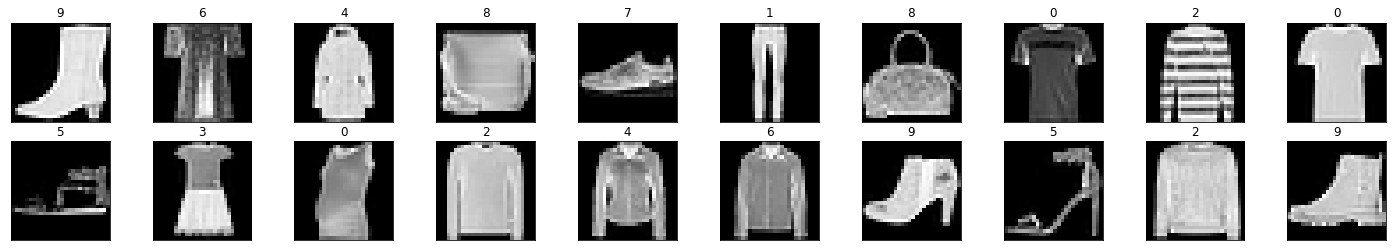

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# get one batch of the training images and plot them
images, labels = iter(train_loader).next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()), color=('black'))

## Network Architectures

The input is going to be an image (28x28x1) and the output must be a classification in 10 classes (0-9).

In [6]:
import torch.nn as nn

# define the NN architecture
class FCNet(nn.Module):
    def __init__(self, input_dim, output_dim, *hiden_layers):
        super().__init__()
        
        self.input_dim = input_dim
        layers = []
        last_dim = input_dim
                
        for idx, dim in enumerate(hiden_layers):
            layers.append(nn.Linear(last_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
            last_dim = dim
            
        layers.append(nn.Linear(last_dim, output_dim))
        
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input, the -1 is like a wild card
        x = x.view(-1, self.input_dim)
        # pass though the network
        x = self.fc(x)
        return x

In [9]:
# create the network with 2 hidden layers of 250 neurons each one
model_fc = FCNet(28*28*1, 10, 250, 250)
print(model_fc)

FCNet(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=250, out_features=250, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=250, out_features=10, bias=True)
  )
)


In [25]:
# define the NN architecture
class ConvNet(nn.Module):
    def __init__(self, input_dim, input_depth, output_dim, hiden_layers):
        super().__init__()
        
        layers = []
        last_dim = input_dim
        last_depth = input_depth
        next_depth = 32
        
        for i in range(hiden_layers):
            layers.append(nn.Conv2d(last_depth, next_depth, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            last_dim = last_dim / 4
            last_depth = next_depth
            next_depth = 2 * next_depth
        
        self.features = nn.Sequential(*layers)
            
        self.classifier = nn.Linear(int(last_dim * last_depth), output_dim)
        self.input_dim = int(last_dim * last_depth)

    def forward(self, x):
        # pass though the network
        x = self.features(x)
        x = x.view(-1, self.input_dim)
        x = self.classifier(x)
        return x

In [28]:
# create the network with 2 convolutional layers and a fully ocnnected as classifier
model_conv = ConvNet(28*28, 1, 10, 2)
print(model_conv)

ConvNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Linear(in_features=3136, out_features=10, bias=True)
)


###  Loss Function and Optimizers

In [29]:
# cross-entropy loss
loss_fn = nn.CrossEntropyLoss()

# adam optimizer
optimizer_fc = torch.optim.Adam(model_fc.parameters())
optimizer_conv = torch.optim.Adam(model_conv.parameters())

## Train

In [30]:
# this function checks if GPU is available, if it is we will use to train the model
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
get_device()

device(type='cuda')

In [31]:
# this function trains the model for one epoch
def train(model, dataloader, optimizer, loss_fn):
    # check if GPU is available, if it is use it
    device = get_device()
    # pass the model to the device and put it in training mode
    model.to(device)
    model.train()
    # initialize the loss
    total_loss = 0.0
    # for every batch
    for batch_idx, (data, target) in enumerate(dataloader):
        # use GPU if available
        data, target = data.to(device), target.to(device)
        # restart the gradient
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # calculate the loss
        loss = loss_fn(output, target)
        # back propagation
        loss.backward()
        optimizer.step()
        # update the loss
        total_loss += loss.item()*len(data)
    return total_loss/len(dataloader.dataset)

In [32]:
# this function evaluate the performance of the model
def test(model, dataloader, loss_fn):
    # check if GPU is available, if it is use it
    device = get_device()
    # pass the model to the device and put it in evaluation mode
    model.to(device)
    model.eval()
    # initialize the loss and the count of correct predictions
    total_loss = 0.0
    correct = 0
    # not need of gradients for test (it may save some time and/or memory)
    with torch.no_grad():
        # for every batch
        for batch_idx, (data, target) in enumerate(dataloader):
            # use GPU if available
            data, target = data.to(device), target.to(device)
            # forward pass
            output = model(data)
            # calculate the loss
            loss = loss_fn(output, target)
            # update the loss
            total_loss += loss.item()*len(data)
            # it is nice to hace the accuracy as well
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the maximum
            correct += pred.eq(target.view_as(pred)).sum().item()
    return total_loss/len(dataloader.dataset), correct/len(dataloader.dataset)

In [33]:
# number of epochs
n_epochs = 10

# we will keep track of the minimum validation loss achived and use it to save or not the model
valid_loss_min = float('INF')
# train the model for n_epochs epochs
for epoch in range(n_epochs):
    train_loss = train(model_fc, train_loader, optimizer_fc, loss_fn)
    valid_loss, valid_acc = test(model_fc, valid_loader, loss_fn)
    print(f'Epoch {epoch+1}/{n_epochs}\t\tTraining loss {train_loss:.4f}\t\tValidation loss {valid_loss:.4f}\t\tValidation accuracy {valid_acc:.4f}')
    
    # save model only if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Saving model...')
        torch.save({'model': str(model_fc), 'state_dict': model_fc.state_dict()}, 'model_fc.pt')
        valid_loss_min = valid_loss

Epoch 1/10		Training loss 0.4039		Validation loss 0.3674		Validation accuracy 0.8569
Saving model...
Epoch 2/10		Training loss 0.3960		Validation loss 0.3530		Validation accuracy 0.8731
Saving model...
Epoch 3/10		Training loss 0.3935		Validation loss 0.3699		Validation accuracy 0.8670
Epoch 4/10		Training loss 0.3928		Validation loss 0.3579		Validation accuracy 0.8682
Epoch 5/10		Training loss 0.3878		Validation loss 0.3544		Validation accuracy 0.8731
Epoch 6/10		Training loss 0.3873		Validation loss 0.3471		Validation accuracy 0.8777
Saving model...
Epoch 7/10		Training loss 0.3880		Validation loss 0.3456		Validation accuracy 0.8773
Saving model...
Epoch 8/10		Training loss 0.3838		Validation loss 0.3578		Validation accuracy 0.8733
Epoch 9/10		Training loss 0.3780		Validation loss 0.3475		Validation accuracy 0.8752
Epoch 10/10		Training loss 0.3786		Validation loss 0.3437		Validation accuracy 0.8791
Saving model...


In [34]:
# number of epochs
n_epochs = 10

# we will keep track of the minimum validation loss achived and use it to save or not the model
valid_loss_min = float('INF')
# train the model for n_epochs epochs
for epoch in range(n_epochs):
    train_loss = train(model_conv, train_loader, optimizer_conv, loss_fn)
    valid_loss, valid_acc = test(model_conv, valid_loader, loss_fn)
    print(f'Epoch {epoch+1}/{n_epochs}\t\tTraining loss {train_loss:.4f}\t\tValidation loss {valid_loss:.4f}\t\tValidation accuracy {valid_acc:.4f}')
    
    # save model only if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Saving model...')
        torch.save({'model': str(model_conv), 'state_dict': model_conv.state_dict()}, 'model_conv.pt')
        valid_loss_min = valid_loss

Epoch 1/10		Training loss 0.4292		Validation loss 0.3163		Validation accuracy 0.8868
Saving model...
Epoch 2/10		Training loss 0.2879		Validation loss 0.2718		Validation accuracy 0.9000
Saving model...
Epoch 3/10		Training loss 0.2503		Validation loss 0.2686		Validation accuracy 0.9007
Saving model...
Epoch 4/10		Training loss 0.2237		Validation loss 0.2440		Validation accuracy 0.9103
Saving model...
Epoch 5/10		Training loss 0.2022		Validation loss 0.2487		Validation accuracy 0.9072
Epoch 6/10		Training loss 0.1820		Validation loss 0.2545		Validation accuracy 0.9086
Epoch 7/10		Training loss 0.1687		Validation loss 0.2343		Validation accuracy 0.9179
Saving model...
Epoch 8/10		Training loss 0.1542		Validation loss 0.2377		Validation accuracy 0.9158
Epoch 9/10		Training loss 0.1420		Validation loss 0.2454		Validation accuracy 0.9143
Epoch 10/10		Training loss 0.1299		Validation loss 0.2630		Validation accuracy 0.9117


###  Load "the best" Model

In [36]:
saved = torch.load('model_fc.pt')
model_fc.load_state_dict(saved['state_dict'], strict=False) # strict false allow us to partially load a model or load a partial model

<All keys matched successfully>

In [37]:
saved = torch.load('model_conv.pt')
model_conv.load_state_dict(saved['state_dict'], strict=False) # strict false allow us to partially load a model or load a partial model

<All keys matched successfully>

## Test

In [38]:
test_loss, test_acc = test(model_fc, test_loader, loss_fn)
print(f'Test loss {test_loss:.4f}\t\tTest accuracy {test_acc:.4f}')

Test loss 0.3672		Test accuracy 0.8694


In [39]:
test_loss, test_acc = test(model_conv, test_loader, loss_fn)
print(f'Test loss {test_loss:.4f}\t\tTest accuracy {test_acc:.4f}')

Test loss 0.2631		Test accuracy 0.9117


As we can see the convolutional model has better perfom than the fully connected one (5% more accuracy is quite a lot in these cases).

### Visualize Results

We are going to plot the images where one of our models made a mistake. We will be able to see that where the fully connected neural network fails the convolutional neural network still perform well and almost in no one case the convolutional model fails and the fully connected guess well.

In [67]:
model_fc.cpu()
model_conv.cpu()

imgs = []
labls = []

for images, labels in train_loader:
    out_fc = model_fc(images)
    preds_fc = out_fc.argmax(dim=1, keepdim=True).squeeze()
    
    out_conv = model_conv(images)
    preds_conv = out_conv.argmax(dim=1, keepdim=True).squeeze()
    
    fails = (preds_fc != labels) + (preds_conv != labels)
    for im in images[fails]:
        imgs.append(im.numpy())
    indices = np.array(range(batch_size))
    for idx in indices[fails]:
        labls.append((labels[idx], preds_fc[idx], preds_conv[idx]))

5686


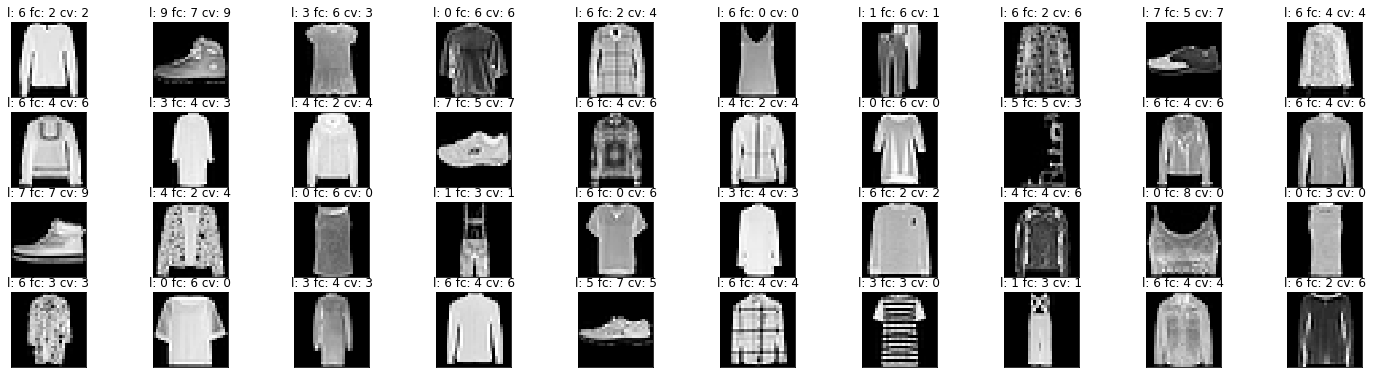

In [68]:
num = len(labls)
print(num)
num = 40
fig = plt.figure(figsize=(25, 8))
for idx in range(num):
    ax = fig.add_subplot(int(num/10)+1, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(imgs[idx]), cmap='gray')
    ax.set_title(f'l: {labls[idx][0].item()} fc: {labls[idx][1].item()} cv: {labls[idx][2].item()}', color=('black'))
    
    